#  Machine learning assisted sensing of biomolecules by means of Raman spectroscopy

## Non-invasive glucose monitoring using critical-depth Raman spectroscopy

This dataset contains the Raman spectra from the thenar (the group of muscles on the palm of the human hand at the base of the thumb) of 41 patients with diabetes, with age between 20 and 60 years with the goal of obtaining a system that could sense noninvasively the glucose concentration in blood.

Data: https://plos.figshare.com/articles/Critical-depth_Raman_spectroscopy_enables_home-use_non-invasive_glucose_monitoring/6261386

### Read samples
The samples in this case are contained in a MATLAB file that has to be added to the Spectra object using the `addSpectrum` method:

```
spectra = Spectra()
for spectrum in raw_data:
    spectra.addSpectrum(spectrum.wavenumbers, spectrum.intensity)
```

In [3]:
# Libraries needed
import warnings
import scipy.io as sp
import ramanpy as rpy
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from scipy.stats import linregress
warnings.filterwarnings("ignore") # To ignore annoying warnings on deprecations that third-party libraries perform

In [5]:
# Read spectroscopy data
matfile = sp.loadmat("measurements/pone.0197134.s005.mat")
spectra = rpy.Spectra()

wavenumbers = matfile['Xfilt']['Axis'][0][0][0]
for intensity in matfile['Xfilt']['Data'][0][0]:
    spectra.addSpectrum(wavenumbers.astype(np.float), intensity)

### Read Metadata
Information just like the reference predicted value, the collection depth and the patient ID was read in order to plot and differentiate patients for the following statistical models.

In [6]:
# To-predict values, corresponding to the concentrations
to_predict = matfile['Xfilt']['Yref'][0][0]
to_predict = np.concatenate(to_predict)

# Skin-depth
collection_depth = matfile['Xfilt']['Settings'][0][0]
collection_depth = np.concatenate(collection_depth)

# Patient info
patient_info = matfile['Xfilt']['ID'][0][0]

### Other necessary functions
The functions below are used to show the regression plot with the Parkes Grid, just like the original paper did. Most functions related to the Parkes Error Grid were obtained from: https://github.com/kriventsov/Clarke-and-Parkes-Error-Grids

In [2]:
def parkes_error_zone_detailed(act, pred, diabetes_type):
    """
    This function outputs the Parkes Error Grid region (encoded as integer)
    for a combination of actual and predicted value
    for type 1 and type 2 diabetic patients
    Based on the article 'Technical Aspects of the Parkes Error Grid':
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876371/
    """
    def above_line(x_1, y_1, x_2, y_2, strict=False):
        if x_1 == x_2:
            return False

        y_line = ((y_1 - y_2) * act + y_2 * x_1 - y_1 * x_2) / (x_1 - x_2)
        return pred > y_line if strict else pred >= y_line

    def below_line(x_1, y_1, x_2, y_2, strict=False):
        return not above_line(x_1, y_1, x_2, y_2, not strict)

    def parkes_type_1(act, pred):
        # Zone E
        if above_line(0, 150, 35, 155) and above_line(35, 155, 50, 550):
            return 7
        # Zone D - left upper
        if (pred > 100 and above_line(25, 100, 50, 125) and
                above_line(50, 125, 80, 215) and above_line(80, 215, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 550, 150)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 50, 80) and
                above_line(50, 80, 70, 110) and above_line(70, 110, 260, 550)):
            return 4
        # Zone C - right lower
        if (act > 120 and below_line(120, 30, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 140, 170) and
                above_line(140, 170, 280, 380) and (act < 280 or above_line(280, 380, 430, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 170, 145) and
                below_line(170, 145, 385, 300) and (act < 385 or below_line(385, 300, 550, 450))):
            return 1
        # Zone A
        return 0

    def parkes_type_2(act, pred):
        # Zone E
        if (pred > 200 and above_line(35, 200, 50, 550)):
            return 7
        # Zone D - left upper
        if (pred > 80 and above_line(25, 80, 35, 90) and above_line(35, 90, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 410, 110) and below_line(410, 110, 550, 160)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 280, 550)):
            return 4
        # Zone C - right lower
        if (below_line(90, 0, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 230, 330) and
                (act < 230 or above_line(230, 330, 440, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 90, 80) and below_line(90, 80, 330, 230) and
                (act < 330 or below_line(330, 230, 550, 450))):
            return 1
        # Zone A
        return 0

    if diabetes_type == 1:
        return parkes_type_1(act, pred)

    if diabetes_type == 2:
        return parkes_type_2(act, pred)

    raise Exception('Unsupported diabetes type')

parkes_error_zone_detailed = np.vectorize(parkes_error_zone_detailed)


def zone_accuracy(act_arr, pred_arr, mode='parkes', detailed=False, diabetes_type=1):
    """
    Calculates the average percentage of each zone based on Clarke or Parkes
    Error Grid analysis for an array of predictions and an array of actual values
    """
    acc = np.zeros(9)
    if mode == 'clarke':
        pass
    elif mode == 'parkes':
        res = parkes_error_zone_detailed(act_arr, pred_arr, diabetes_type)
    else:
        raise Exception('Unsupported error grid mode')

    acc_bin = np.bincount(res)
    acc[:len(acc_bin)] = acc_bin

    if not detailed:
        acc[1] = acc[1] + acc[2]
        acc[2] = acc[3] + acc[4]
        acc[3] = acc[5] + acc[6]
        acc[4] = acc[7] + acc[8]
        acc = acc[:5]

    return acc / sum(acc)


def plot_parkes_grid():    
    plt.text(25,28, "A", fontsize=20)
    plt.text(28,25, "A", fontsize=20)
    plt.text(15,28, "B", fontsize=20)
    plt.text(28,15, "B", fontsize=20)
    plt.text(8.5,28, "C", fontsize=20)
    plt.text(28,8.5, "C", fontsize=20)
    plt.text(4,28, "D", fontsize=20)
    plt.text(28,3, "D", fontsize=20)
    plt.text(1,28, "E", fontsize=20)
    plt.plot(np.array([50, 50, 170, 385, 550]) / 18, np.array([0, 30, 145, 300, 450]) / 18, "-", color="black")
    plt.plot(np.array([0, 30, 140, 280, 430]) / 18, np.array([50, 50, 170, 380, 550]) / 18, "-", color="black")
    plt.plot(np.array([120, 120, 260, 550]) / 18, np.array([0, 30, 130, 250]) / 18, "-", color="black")
    plt.plot(np.array([0, 30, 50, 70, 260]) / 18, np.array([60, 60, 80, 110, 550]) / 18, "-", color="black")
    plt.plot(np.array([250, 250, 550]) / 18, np.array([0, 40, 150]) / 18, "-", color="black")
    plt.plot(np.array([0, 25, 50, 80, 125]) / 18, np.array([100, 100, 125, 215, 550]) / 18, "-", color="black")
    plt.plot(np.array([0, 35, 50]) / 18, np.array([150, 155, 550]) / 18, "-", color="black")
    plt.plot(np.array([0, 550]) / 18, np.array([0, 550]) / 18, "-", color="black")
    plt.xlabel("Reference glucose (mmol/L)")
    plt.ylabel("Predicted glucose (mmol/L)")


def MARDCalc(y, y_pred):
    y = y.reshape(-1)
    y_pred = y_pred.reshape(-1)
    MARD = 0
    for i in range(0, len(y)):
        MARD += abs(y[i] - y_pred[i]) / y[i]
    MARD = MARD / len(y)
    return MARD

### Data manipulation
The metadata dataframe was assigned the correspondant data. Including the discretization of the collection depths and the glucose concentration into ranges.

In [7]:
spectra_info = pd.DataFrame()
spectra_info["patient_id"] = patient_info[:, 0]
spectra_info["measurement_day"] = patient_info[:, 1]
spectra_info["glucose_concentration"] = to_predict

# Discretize collection depth
spectra_info["collection_depth"] = ""
spectra_info.loc[collection_depth < 240, "collection_depth"] = "140-240"
spectra_info.loc[np.logical_and(collection_depth < 270, collection_depth >= 240), "collection_depth"] = "240-270"
spectra_info.loc[collection_depth >= 270, "collection_depth"] = ">270"

In [8]:
# Discretize the glucose concentration
spectra_info["glucose_concentration_range"] = ""
spectra_info.loc[to_predict < 5, "glucose_concentration_range"] = "0-5"
spectra_info.loc[np.logical_and(to_predict < 10, to_predict >= 5), "glucose_concentration_range"] = "5-10"
spectra_info.loc[np.logical_and(to_predict < 15, to_predict >= 10), "glucose_concentration_range"] = "10-15"
spectra_info.loc[np.logical_and(to_predict < 20, to_predict >= 15), "glucose_concentration_range"] = "15-20"
spectra_info.loc[np.logical_and(to_predict < 25, to_predict >= 20), "glucose_concentration_range"] = "20-25"
spectra_info.loc[np.logical_and(to_predict <= 30, to_predict >= 25), "glucose_concentration_range"] = "25-30"

In [9]:
# Show the structure of the spectra_info table
spectra_info.head()

,patient_id,measurement_day,glucose_concentration,collection_depth,glucose_concentration_range
0,16,0,14.400000,240-270,10-15
1,16,0,14.100000,240-270,10-15
2,16,1,7.070588,240-270,5-10
3,16,1,8.300000,240-270,5-10
4,16,1,12.700000,240-270,10-15


The figure below contains the glucose concentration VS the collection depth was presented to see if the ranges varied between the different collection depths, which was not the case.

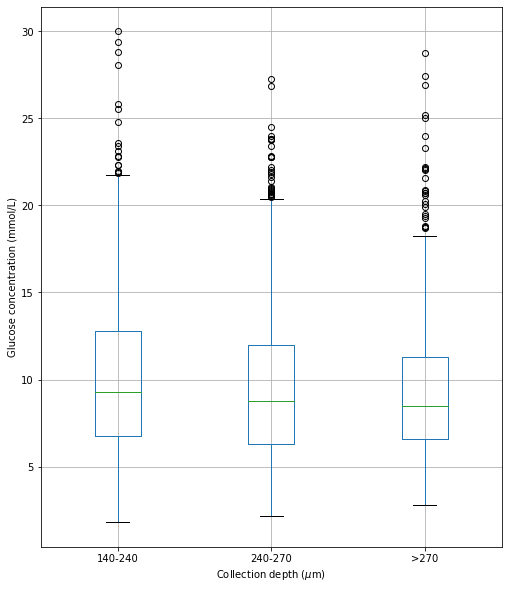

In [7]:
spectra_info.boxplot("glucose_concentration", "collection_depth", figsize=(8,10))
plt.suptitle("")
plt.title("")
plt.xlabel("Collection depth ($\mu$m)")
plt.ylabel("Glucose concentration (mmol/L)")

This figure below that represents the glucose concentration VS the different patient's IDs shows that each patient had a completely different range from one another, therefore, it affirms what the authors claimed that the difference between patients wouldn't allow for an unique viable model.

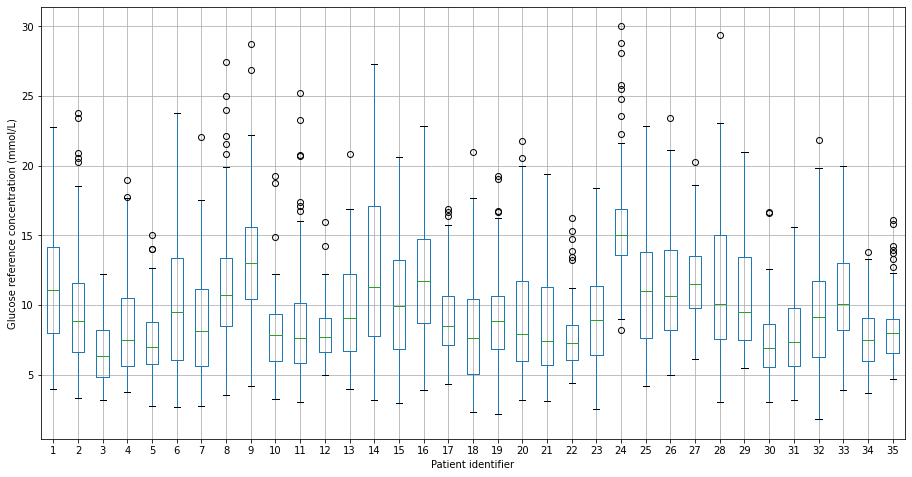

In [9]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
spectra_info.boxplot("glucose_concentration", "patient_id", ax=ax)
fig.suptitle("")
ax.set_title("")
ax.set_xlabel("Patient identifier")
ax.set_ylabel("Glucose reference concentration (mmol/L)")

#### Split into first 25 days of measurement (training) and last 5 days (testing)
The original paper performed the training and testing by dividing the data in the first 25 days and the last 5 days of a patient's measurement days. For fair comparison, we did the same.

In [10]:
last_five_days_index = []
first_five_days_index = []
for patient, patient_info in spectra_info.sort_values("measurement_day").groupby("patient_id").__iter__():
    cond1 = np.logical_and(patient_info.measurement_day.isin(patient_info.measurement_day.unique()[-5:]),
                         patient_info.collection_depth == "240-270")
    cond1 = np.logical_or(cond1, patient_info.collection_depth == ">270")
    cond2 = np.logical_and(patient_info.measurement_day.isin(patient_info.measurement_day.unique()[:-5]),
                         patient_info.collection_depth == "240-270")
    cond2 = np.logical_or(cond2, patient_info.collection_depth == ">270")
    
    last_five_days = patient_info.loc[cond1]
    last_five_days_index.append(last_five_days.index)
    first_five_days = patient_info.loc[cond2]
    first_five_days_index.append(first_five_days.index)

#### Baseline removal + Smoothing
To perform baseline removal and smoothing the following methods are used:

```
spectra.removeBaseline(region_of_interest_to_keep, fittin_method, to_modify_original_object, **kwargs)
spectra.smoothSignal(method, to_modify_original_object, **kwargs)
```

In most of the cases for the thesis the preferred method was drPLS, which stands for **doubly reweighted penalized least squares**, on the Rampy library it replicates the algorithm of the following paper: https://doi.org/10.1364/AO.58.003913.

The `**kwargs` are a set of arguments that are passed to the function as a dictionary, in this case the ratio (difference in change between the hyperparameters fitting) was only specified to increase the accuracy as the default value was $10^{-2}$.

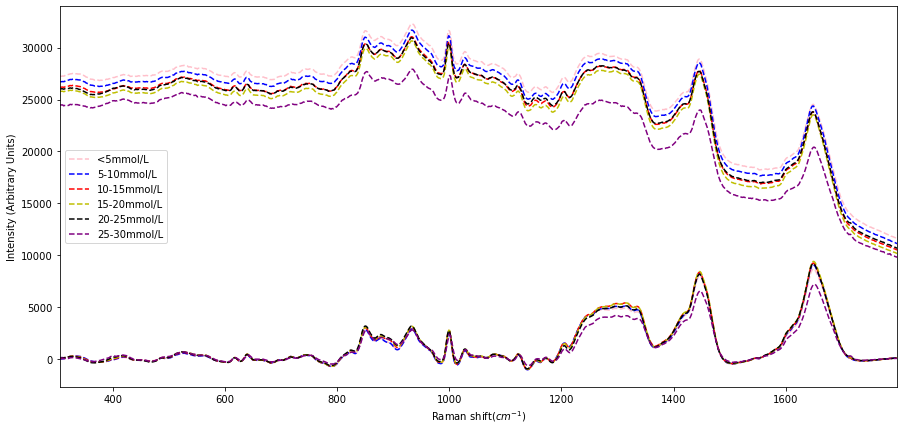

In [14]:
# Different reference concentrations ranges
lessthan5 = spectra.intensity[to_predict < 5].astype(float)
between5and10 = spectra.intensity[np.logical_and(to_predict < 10, to_predict >= 5)].astype(float)
between10and15 = spectra.intensity[np.logical_and(to_predict < 15, to_predict >= 10)].astype(float)
between15and20 = spectra.intensity[np.logical_and(to_predict < 20, to_predict >= 15)].astype(float)
between20and25 =  spectra.intensity[np.logical_and(to_predict < 25, to_predict >= 20)].astype(float)
between25and30 = spectra.intensity[np.logical_and(to_predict <= 30, to_predict >= 25)].astype(float)

# Plot space and prior to pre-processing
plt.figure(figsize=(15,7))
plt.plot(spectra.wavenumbers, lessthan5.mean(axis=0), "--", label="<5mmol/L", color="pink")
plt.plot(spectra.wavenumbers, between5and10.mean(axis=0), "--", label="5-10mmol/L", color="b")
plt.plot(spectra.wavenumbers, between10and15.mean(axis=0), "--", label="10-15mmol/L", color="r")
plt.plot(spectra.wavenumbers, between15and20.mean(axis=0), "--", label="15-20mmol/L", color="y")
plt.plot(spectra.wavenumbers, between20and25.mean(axis=0), "--", label="20-25mmol/L", color="black")
plt.plot(spectra.wavenumbers, between25and30.mean(axis=0), "--", label="25-30mmol/L", color="purple")

# The ROI doesn't actually do anything when drPLS is set as method
ROI = np.array([[200, 300], [700, 1000], [1600, 2000], [2250, 2700], [3100, 3600]])
start_time = time.time()
spectra.removeBaseline(roi=ROI, method="drPLS", inplace=True, **{"ratio": 1e-3})
print("--- %s seconds ---" % (time.time() - start_time))
spectra.smoothSignal(method="hanning", inplace=True)

# Plot post pre-processing
plt.plot(spectra.wavenumbers, lessthan5.mean(axis=0), "--", color="pink")
plt.plot(spectra.wavenumbers, between5and10.mean(axis=0), "--", color="b")
plt.plot(spectra.wavenumbers, between10and15.mean(axis=0), "--", color="r")
plt.plot(spectra.wavenumbers, between15and20.mean(axis=0), "--", color="y")
plt.plot(spectra.wavenumbers, between20and25.mean(axis=0), "--", color="black")
plt.plot(spectra.wavenumbers, between25and30.mean(axis=0), "--", color="purple")

# Additions of the plotted figure
plt.xlabel("Raman shift($cm^{-1}$)")
plt.ylabel("Intensity (Arbitrary Units)")
plt.xlim([spectra.wavenumbers.min(), spectra.wavenumbers.max()])
plt.legend()

### Prediction
#### Split information by patient and find best classifier

In [ ]:
patients = []
conditions = []
for i in range(0, len(first_five_days_index)):
    if(first_five_days_index[i].shape[0] > 0):
        condition = list()
        condition.extend(first_five_days_index[i])
        conditions.append(condition)
        patients.append(spectra.loc[condition])
        patients[-1].testRegressors(to_predict[condition], False, **dict(verbose = 0))

#### Train models
The *ISUP*s (Inter Subject Unified Performance) were also calculated in order to be able to differentiate the performance of this system and the original paper.

The ISUP is calculated as: $ISUP = (A + B - MARD) \cdot slope \cdot R^2 \cdot \frac{1}{Y_{Median}}$

The *A* and *B* are spaces in the Parkes Error Grid which would allow the predicted value to have the least difference from the original reference value. The *MARD* is the *Mean Absolute Relative Difference*, the *slope* of the linear regression, the *R2* coefficient and the *YMedian* the median for each patient's measurements.

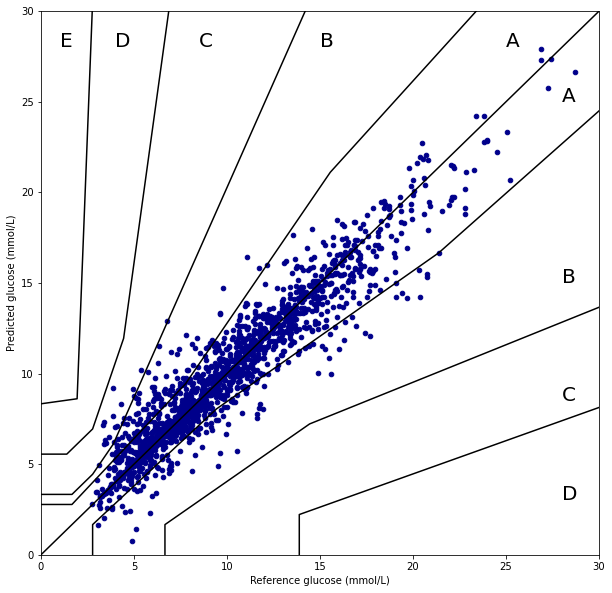

In [477]:
ISUPs = []
MARDs = []
As = []
Bs = []
R2s = []
slopes = []

plt.figure(figsize=(10,10))
plt.xlim([0,30])
plt.ylim([0,30])
plot_parkes_grid()
total_samples = 0

for i in range(0, len(patients)):
    patient = patients[i]
    condition = conditions[i]
    results = patient.trainModel(to_predict[condition], False)
    total_samples += len(to_predict[condition])
    reg = linregress(results["Y_train"], results["Y_train_pred"].reshape(-1))
    A, B, C, D, E = zone_accuracy(results["Y_train"] * 18, results["Y_train_pred"].reshape(-1) * 18, mode="parkes")
    MARD = MARDCalc(results["Y_train"], results["Y_train_pred"])
    R2 = r2_score(results["Y_train"], results["Y_train_pred"].reshape(-1))
    slope = reg.slope
    YMedian = np.median(results["Y_train"])
    ISUP = (A*100 + B*100 - MARD*100) * slope * R2 * (1/YMedian)
    ISUPs.append(ISUP)
    MARDs.append(MARD)
    As.append(A)
    Bs.append(B)
    R2s.append(R2)
    slopes.append(slope)
    if(ISUP > 0.5): # Only ISUPs > 0.5 were considered, just like the original paper
        plt.scatter(results["Y_train"], results["Y_train_pred"].reshape(-1), color="darkblue", s=21)

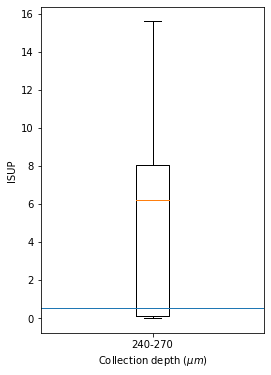

In [469]:
plt.figure(figsize=(4,6))
plt.boxplot(ISUPs, labels=["240-270"], showfliers=False)
plt.plot([0.5, 1.5], [0.5, 0.5], "-", linewidth=1, label="Threshold of 0.5")
# plt.scatter(np.ones_like(ISUPs), ISUPs, color="black", s=15)
plt.xlabel("Collection depth ($\mu m$)")
plt.ylabel("ISUP")

In [478]:
print(f"MARD: {np.mean(MARDs)}\nSlope: {np.mean(slopes)}\nA (%): {np.mean(As)}\nB (%): {np.mean(Bs)}\nR2: {np.mean(R2s)}\nTotal samples: {total_samples}")

MARD: 0.1810827042002389
Slope: 0.59200196931657
A (%): 0.7262682611929151
B (%): 0.22917825602011324
R2: 0.601216235222558
Total samples: 2627


#### Repeat for validating dataset (5 last days)

In [465]:
patients_predict = []
j = 0
for i in range(0, len(last_five_days_index)):
    if(last_five_days_index[i].shape[0] > 0):
        condition = list()
        condition.extend(last_five_days_index[i])
        patients_predict.append(spectra.loc[condition])
        patients_predict[-1]._model = patients[j]._model
        j += 1

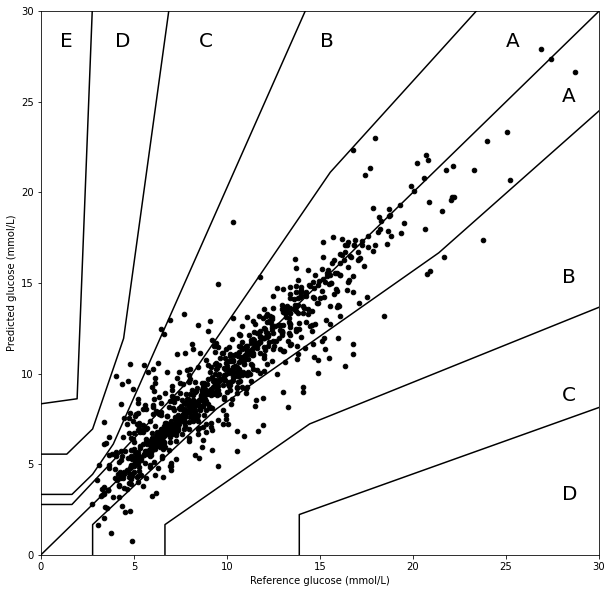

In [474]:
ISUPs_t = []
MARDs_t = []
As_t = []
Bs_t = []
R2s_t = []
slopes_t = []
plt.figure(figsize=(10,10))
plt.xlim([0,30])
plt.ylim([0,30])
plot_parkes_grid()
total_samples = 0
for i in range(len(patients)):
    if(ISUPs[i] > 0.5):
        patient = patients_predict[i]
        y_pred = patient.predictFromModel(-1)
        y_test = to_predict[patient.index.values]
        total_samples += len(y_test)
        plt.scatter(y_test, y_pred, color="black", s=21)
        reg = linregress(y_test, y_pred.reshape(-1))
        A, B, _, _, _ = zone_accuracy(y_test * 18, y_pred.ravel() * 18, mode="parkes")
        MARD = MARDCalc(y_test,y_pred)
        R2 = r2_score(y_test, y_pred.reshape(-1))
        slope = reg.slope
        YMedian = np.median(y_test)
        ISUP = (A*100 + B*100 - MARD*100) * slope * R2 * (1/YMedian)
        ISUPs_t.append(ISUP)
        MARDs_t.append(MARD)
        As_t.append(A)
        Bs_t.append(B)
        R2s_t.append(R2)
        slopes_t.append(slope)

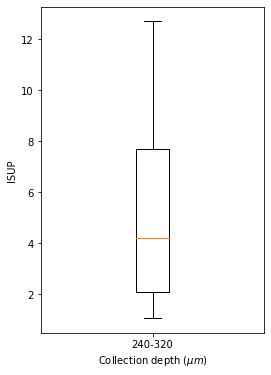

In [473]:
plt.figure(figsize=(4,6))
plt.boxplot(ISUPs_t, labels=["240-320"], showfliers=False)
plt.xlabel("Collection depth ($\mu m$)")
plt.ylabel("ISUP")

In [475]:
print(f"MARD (%): {np.mean(MARDs_t)*100}\nSlope: {np.mean(slopes_t)}\nA (%): {np.mean(As_t)*100}\nB (%): {np.mean(Bs_t)*100}\nR2: {np.mean(R2s_t)}\nTotal samples: {total_samples}")

MARD (%): 16.57387391738776
Slope: 0.7532185124995435
A (%): 73.85053710677865
B (%): 24.024940684967074
R2: 0.7021776340472284
Total samples: 1001
